In [1]:
import glob
import os
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')


import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from trainer import Trainer, TrainerConfig
from utils import set_seed


from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from utils import print_full
from scipy.ndimage import gaussian_filter, uniform_filter


import matplotlib.pyplot as plt
from utils import *
from visualize import *
set_plot_params()
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"


from model_neuroformer import GPT, GPTConfig, neuralGPTConfig
from trainer import Trainer, TrainerConfig


import json
# for i in {1..10}; do python3 -m gather_atts.py; done

# set os cuda device


In [2]:
data_dir = "./data/VisNav_VR_Expt"

if not os.path.exists(data_dir):
    print("Downloading data...")
    import gdown
    url = "https://drive.google.com/drive/folders/117S-7NmbgrqjmjZ4QTNgoa-mx8R_yUso?usp=sharing"
    gdown.download_folder(id=url, quiet=False, use_cookies=False, output="data/")



In [3]:
# load config files
import yaml

base_path = "./configs/visnav"

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
    dconf = yaml.full_load(stream)

import omegaconf
from omegaconf import OmegaConf

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
dconf = OmegaConf.create(dconf)




In [4]:
import mat73
import scipy

data_path = "data/VisNav_VR_Expt/experiment_data.mat"
data = mat73.loadmat(data_path)['neuroformer']

data_response_path = "/data5/antonis/neuroformer/data/VisNav_VR_Expt/yiyi/experiment_data_selected.mat"
data_response = scipy.io.loadmat(data_response_path)
print(data.keys())



dict_keys(['eyerad', 'phi', 'speed', 'spiketimes', 't', 'th', 'trialsummary', 'vid_sm'])


In [11]:
from SpikeVidUtils import trial_df, get_df_visnav


stimulus = data['vid_sm']
response = data['spiketimes']['spks']
trial_data = data['trialsummary']

df = get_df_visnav(response, trial_data)

behavior_vars = ['t', 'speed']        # ['t', 'eyerad', 'phi', 'speed', 'th']
behavior = pd.DataFrame({k: data[k] for k in behavior_vars})

# rename t to time
behavior = behavior.rename(columns={'t': 'Time'})
behavior_interp = behavior.interpolate(method='linear', limit_direction='forward', limit=len(behavior*10), axis=0)

In [6]:
frame_window = 0.2
window = 0.05
window_prev = 0.2
window_behavior = window
dt = 0.01
dt_frames = 0.05
dt_vars = 0.05
intervals = None

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['real_interval'] = make_intervals(df, 0.05)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)
behavior['Interval'] = make_intervals(behavior, window)
behavior['Interval_2'] = make_intervals(behavior, window_prev)

# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']



In [7]:
# int_trials = df.groupby(['Interval', 'Trial']).size()
# print(int_trials.mean())
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
var_group = 'Interval'
n_unique = len(df.groupby([var_group, 'Trial']).size())
# df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
df.groupby([var_group, 'Trial']).size().sort_values(ascending=False).nlargest(int(0.05 * n_unique))
df.groupby([var_group, 'Trial']).size().sort_values(ascending=False).nsmallest(int(0.75 * n_unique))

Interval  Trial
2.80      42        1
4.00      43        1
1.60      135       1
8.40      185       1
2.95      57        1
                   ..
5.05      279      23
1.80      130      23
0.40      194      23
1.40      297      23
3.40      232      23
Length: 24516, dtype: int64

In [8]:
from SpikeVidUtils import SpikeTimeVidData2

## resnet3d feats
n_frames = round(frame_window * 1/dt_frames)
kernel_size = (n_frames, 5, 5)
n_embd = 256
n_embd_frames = 64
frame_feats = stimulus

frame_block_size = ((n_frames // kernel_size[0] * 30 * 100) // (n_embd_frames))
frame_feats = torch.tensor(stimulus, dtype=torch.float32)
conv_layer = True

assert (window_behavior) % dt_vars < 1e-5, "window + window_prev must be divisible by dt_vars"
samples_per_behavior = int((window + window_prev) // dt_vars)
behavior_block_size = int((window + window_prev) // dt_vars) * (len(behavior.columns) - 1)

prev_id_block_size = 300
id_block_size = 100   #
block_size = frame_block_size + id_block_size + prev_id_block_size
frame_memory = frame_window // dt_frames
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

neurons = sorted(list(set(df['ID'].unique())))
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }



In [9]:
import random

r_split = 0.8
all_trials = sorted(df['Trial'].unique())
train_trials = random.sample(all_trials, int(len(all_trials) * r_split))

train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]

In [10]:
from SpikeVidUtils import SpikeTimeVidData2


train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset='visnav',
                                  behavior=behavior, dt_vars=dt_vars, 
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset='visnav',
                                  behavior=behavior, dt_vars=dt_vars, 
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior)

print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')



Length: 485018 Neurons: 2204
id block size: 100
frames: 46, id: 100
Length: 129183 Neurons: 2204
id block size: 100
frames: 46, id: 100
train: 24735, test: 6766


In [11]:
loader = DataLoader(train_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)
iterable = iter(loader)

In [12]:
x, y = next(iterable)
# print(x['behavior'].shape, x['behavior_dt'].shape)

In [13]:
for key in x.keys():
    print(key, x[key].shape)

id_prev torch.Size([2, 300])
dt_prev torch.Size([2, 300])
pad_prev torch.Size([2])
id torch.Size([2, 100])
dt torch.Size([2, 100])
pad torch.Size([2])
interval torch.Size([2])
trial torch.Size([2])
behavior torch.Size([2, 3, 4, 1])
behavior_dt torch.Size([2, 4])
frames torch.Size([2, 1, 4, 30, 100])
cid torch.Size([2, 2])
pid torch.Size([2, 2])
f_idx torch.Size([2, 2])


In [14]:
from model_neuroformer import GPT, GPTConfig

layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)   
max_epochs = 100
batch_size = round((32)) * 7
shuffle = True

title =  f'window:{window}_prev:{window_prev}_smooth'

model_path = f"""./models/tensorboard/visnav/trials/VR-speed/{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""

model_conf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        behavior_block_size=behavior_block_size,
                        sparse_mask=False, p_sparse=None, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=mconf.n_state_layers, n_state_history_layers=mconf.n_state_history_layers,
                        n_stimulus_layers=mconf.n_stimulus_layers, self_att_layers=mconf.self_att_layers,
                        n_behavior_layers=mconf.n_behavior_layers,
                        n_head=mconf.n_head, n_embd=mconf.n_embd, 
                        contrastive=True, clip_emb=1024, clip_temp=0.5,
                        conv_layer=conv_layer, kernel_size=kernel_size,
                        temp_emb=True, pos_emb=False,
                        id_drop=0.35, im_drop=0.35, b_drop=0.45,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt, n_embd_frames=n_embd_frames,
                        ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'])  # 0.35

model = GPT(model_conf)



11776
256 23


In [15]:
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=1e-4, 
                    num_workers=4, lr_decay=False, patience=3, warmup_tokens=8e7, 
                    decay_weights=True, weight_decay=0.2, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, 
                    dist=False, save_every=1000)

# trainer = Trainer(model, train_dataset, test_dataset, tconf, model_conf)
# trainer.train()

In [18]:
from neuroformer.utils import predict_raster_recursive_time_auto, get_best_ckpt

model_path = './models/tensorboard/visnav/trials/SGD'
model_path = get_best_ckpt(model_path)
model.load_state_dict(torch.load(model_path))

results_dict = dict()
df_pred = None
df_true = None

top_p = 0.75
top_p_t = 0.75
temp = 1.2
temp_t = 1.2

trials = train_data['Trial'].unique()[:4]
for trial in trials:    # test_data['Trial'].unique():
    # with io.capture_output() a
    #s captured:
        print(f"Trial: {trial}")
        df_trial = df[df['Trial'] == trial]
        trial_dataset = SpikeTimeVidData2(df_trial, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset='visnav',
                                  behavior=behavior, dt_vars=dt_vars, 
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior)
        results_trial = predict_raster_recursive_time_auto(model, trial_dataset, window, window_prev, stoi, itos_dt, itos=itos, 
                                                           sample=True, top_p=top_p, top_p_t=top_p_t, temp=temp, temp_t=temp_t, 
                                                           frame_end=0, get_dt=True, gpu=False, pred_dt=True)
        # results_trial = predict_raster_hungarian(model, loader, itos_dt, top_p=0.75, temp=1)
        # print(f"MAX ID ---- {sorted(results_trial['ID'].unique()[-10])}")
        df_trial_pred, df_trial_true = process_predictions(results_trial, stoi, itos, window)
        print(f"pred: {df_trial_pred.shape}, true: {df_trial_true.shape}" )
        if df_pred is None:
            df_pred = df_trial_pred
            df_true = df_trial_true
        else:
            df_pred = pd.concat([df_pred, df_trial_pred])
            df_true = pd.concat([df_true, df_trial_true])


from analysis import compute_scores
scores = compute_scores(df[df['Trial'].isin(trials)], df_pred)
print(scores)
print(f"pred: {len(df_pred)}, true: {len(df_true)}" )



dir_name = os.path.dirname(model_path)
n_files = len(glob.glob(os.path.join(dir_name, 'df_pred_*.csv')))
model_name = os.path.basename(model_path)
df_pred.to_csv(os.path.join(dir_name, F'df_pred_{n_files}.csv'))

Trial: 2
Length: 628 Neurons: 2204
id block size: 100
frames: 46, id: 100


len pred: 837, len true: 600: 100%|██████████| 43/43 [01:45<00:00,  2.45s/it]


SOS fouuuund: 0
EOS fouuuund: 43
pred: (824, 5), true: (557, 2)
Trial: 3
Length: 382 Neurons: 2204
id block size: 100
frames: 46, id: 100


len pred: 445, len true: 302: 100%|██████████| 15/15 [00:48<00:00,  3.21s/it]


SOS fouuuund: 0
EOS fouuuund: 15
pred: (436, 5), true: (287, 2)
Trial: 4
Length: 488 Neurons: 2204
id block size: 100
frames: 46, id: 100


len pred: 737, len true: 461: 100%|██████████| 42/42 [01:19<00:00,  1.90s/it]


SOS fouuuund: 0
EOS fouuuund: 42
pred: (722, 5), true: (419, 2)
Trial: 5
Length: 775 Neurons: 2204
id block size: 100
frames: 46, id: 100


len pred: 1104, len true: 732: 100%|██████████| 47/47 [01:56<00:00,  2.48s/it]

SOS fouuuund: 0
EOS fouuuund: 47
pred: (1073, 5), true: (685, 2)
defaultdict(<class 'list'>, {'precision': 0.004229755692288073, 'recall': 0.005925571325678738, 'F1': 0.004812740744711336})
pred: 3055, true: 1948


In [19]:
from SpikeVidUtils import set_intevals
from analysis import get_rates_trial, calc_corr_psth

# df_pred_path = "./models/tensorboard/visnav/trials/VR-speed/window:0.05_prev:0.2_smooth/sparse_f:None_id:None/w:0.05_wp:0.2/df_pred_.csv"
# df_pred = pd.read_csv(df_pred_path)
df_pred_full = df_pred
trials = df_pred['Trial'].unique()

df_3 = df[df['Trial'].isin(trials + 2)]
df_1 = df[df['Trial'].isin(trials)]
df_2 = df[df['Trial'].isin(trials + 1)]

df_pred_full = df_pred
df_list = [df_pred_full, df_1, df_2, df_3]

window_pred = 0.5
min_window = window + window_prev
max_window = df['Interval'].max() # - (window)
df_pred_full = set_intevals(df_pred_full, window, window_prev, max_window, window_pred, min_window)
df_1 = set_intevals(df_1, window, window_prev, max_window, window_pred, min_window)
df_2 = set_intevals(df_2, window, window_prev, max_window, window_pred, min_window)
df_3 = set_intevals(df_3, window, window_prev, max_window, window_pred, min_window)

window_pred = window if window_pred is None else window_pred
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))

# labels = sorted(set(df_pred_full['Interval'].unique()))
rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)
rates_2 = get_rates_trial(df_2, labels)
rates_3 = get_rates_trial(df_3, labels)

top_corr_pred = calc_corr_psth(rates_pred, rates_1)
top_corr_real = calc_corr_psth(rates_1, rates_2)
top_corr_real_2 = calc_corr_psth(rates_1, rates_3)

In [20]:
df_pred

,ID,dt,Trial,Interval,Time
0,699,0.0,2,0.5,0.25
1,127,0.0,2,0.5,0.25
2,72,0.0,2,0.5,0.25
3,1851,0.01,2,0.5,0.26
4,1649,0.01,2,0.5,0.26
...,...,...,...,...,...
1068,227,0.03,5,3.0,2.58
1069,875,0.03,5,3.0,2.58
1070,1814,0.03,5,3.0,2.58
1071,1415,0.04,5,3.0,2.59


In [21]:
print(len(test_data[test_data['Trial'].isin(trials)]))
print(len(df_pred[df_pred['Trial'].isin(trials)]))

0
3055


In [22]:
df_list = [df_pred, df_1, df_2, df_3]

for df in df_list:
    # n_intervals = len(df['Interval'].unique())
    unique_trials = df['Trial'].unique()
    n_trials = len(unique_trials)
    print(f"trials: {unique_trials}")
    print(f"n_trials: {n_trials}")

    unique_ids_1, unique_ids_pred = df_1['ID'].unique(), df_pred['ID'].unique()
    n_unique_1, n_unique_pred = len(unique_ids_1), len(unique_ids_pred)
    print(f"unique_ids_1: {n_unique_1}, n_unique_1: {n_unique_pred}")

trials: [2 3 4 5]
n_trials: 4
unique_ids_1: 810, n_unique_1: 970
trials: [2 3 4 5]
n_trials: 4
unique_ids_1: 810, n_unique_1: 970
trials: [3 4 5 6]
n_trials: 4
unique_ids_1: 810, n_unique_1: 970
trials: [4 5 6 7]
n_trials: 4
unique_ids_1: 810, n_unique_1: 970


id_pred: 970, id_true_1: 810, id_true_2: 783
len_pred: 3055, len_true: 2273
real: defaultdict(<class 'list'>, {'precision': 0.8125, 'recall': 0.8125, 'F1': 0.8125})
pred: defaultdict(<class 'list'>, {'precision': 0.11715418751405303, 'recall': 0.16940063269762923, 'F1': 0.13382602637762459})


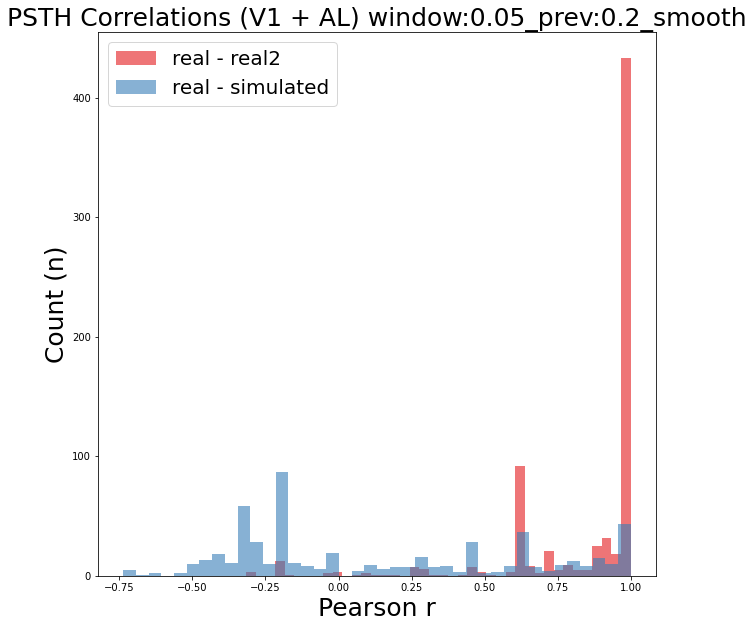

810


<Figure size 432x288 with 0 Axes>

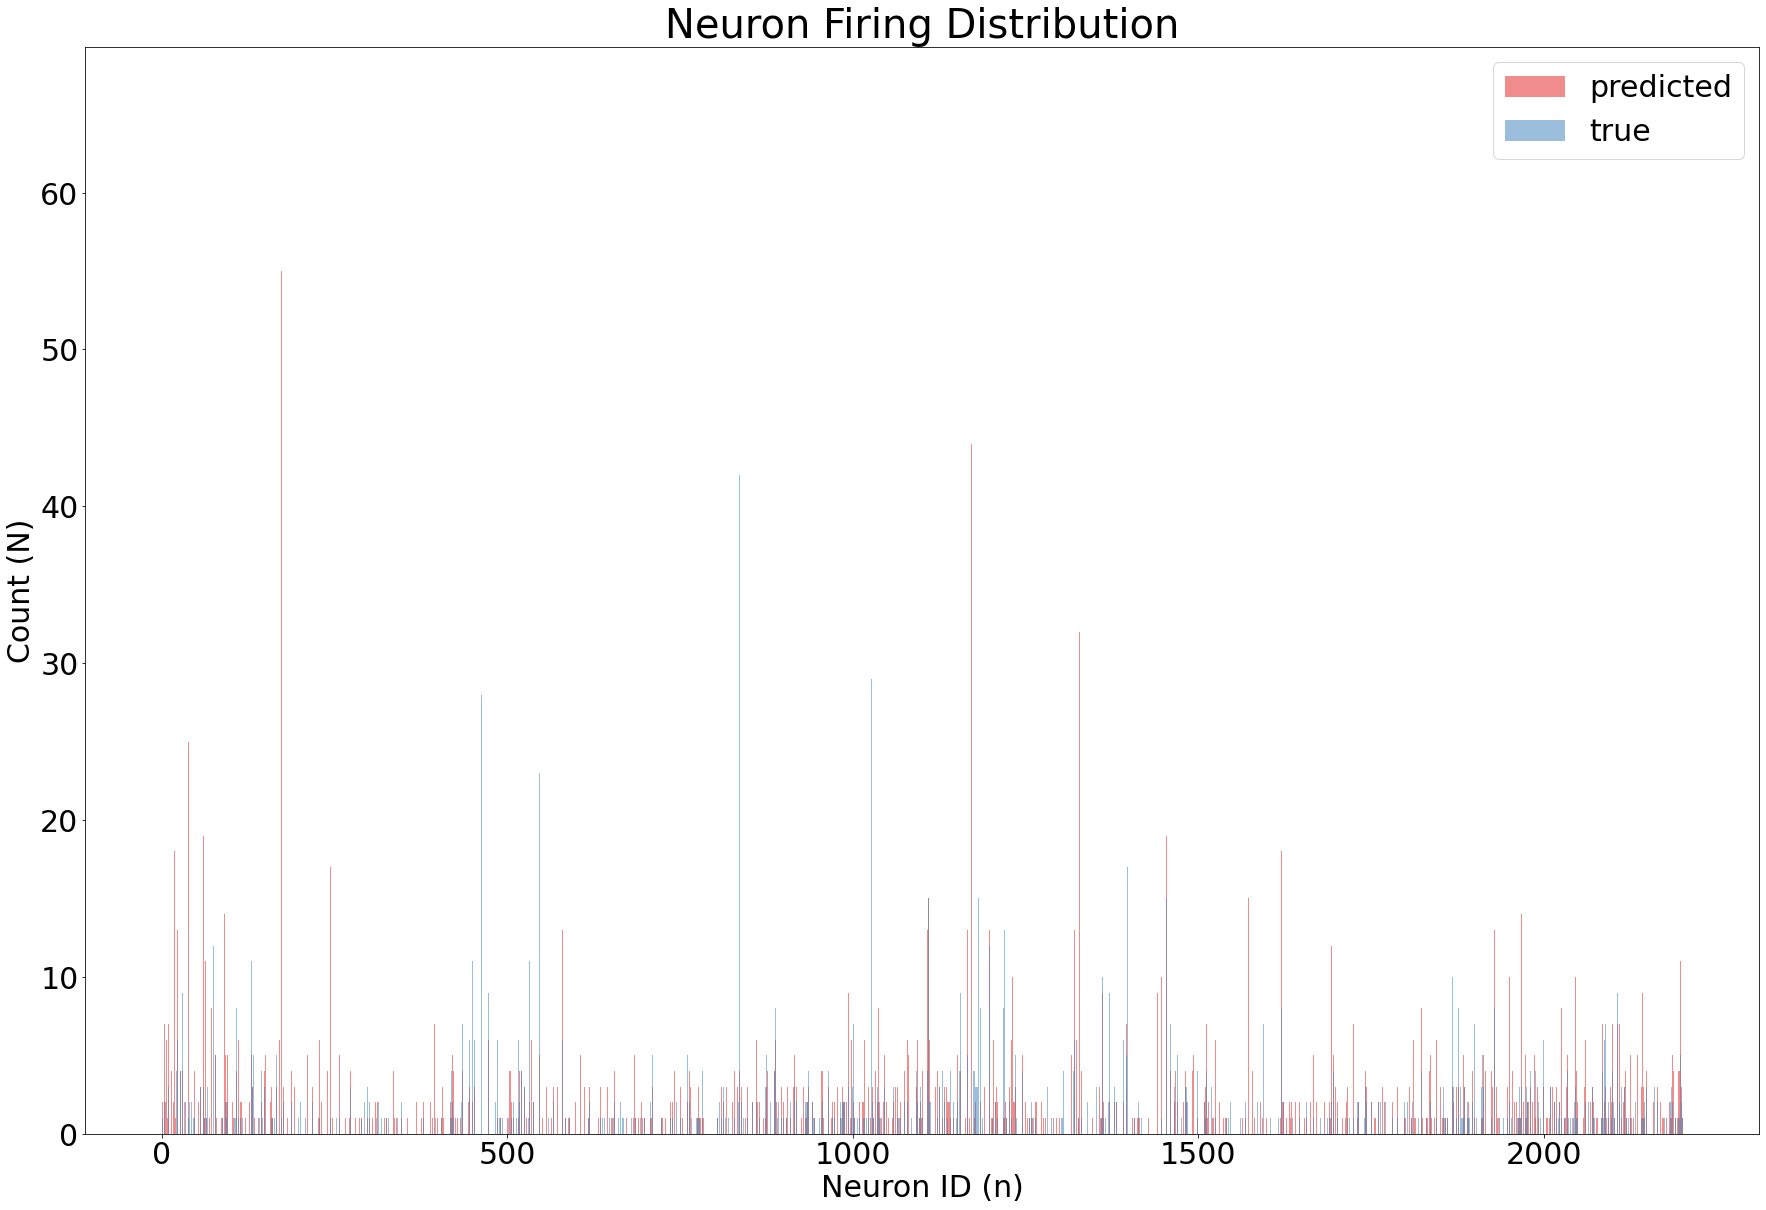

model: window:0.05_prev:0.2_smooth


In [23]:
"""

Evaluate results

"""

from visualize import *

# df_2['Trial'] -= 2
id_pred, id_true_1, id_true_2 = len(df_pred_full['ID'].unique()), len(df_1['ID'].unique()), len(df_2['ID'].unique())
print(f"id_pred: {id_pred}, id_true_1: {id_true_1}, id_true_2: {id_true_2}")

len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred_full, df_2)

scores = compute_scores(df_1, df_2)
pred_scores = compute_scores(df_1, df_pred_full)
print(f"real: {scores}")
print(f"pred: {pred_scores}")


n_bins = 30
set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title(f'PSTH Correlations (V1 + AL) {title}', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
plt.hist(top_corr_real, label='real - real2', alpha=0.6, bins=40)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6, bins=40)
plt.legend(fontsize=20)
plt.show()

dir_name = os.path.dirname(model_path)
model_name = os.path.basename(model_path)

top_p = 0
save_title = title + f'_top_p{top_p}'

plt.savefig(os.path.join(dir_name, F'psth_corr_{save_title}_.svg'))
df_pred.to_csv(os.path.join(dir_name, F'df_pred_{save_title}_.csv'))

plot_distribution(df_1, df_pred_full, save_path=os.path.join(dir_name, F'psth_dist_.svg'))

total_scores = dict()
total_scores['real'] = scores
total_scores['pred'] = pred_scores

print(f"model: {title}")


In [ ]:
from neuroformer.visualize import plot_psth

n_ids = 40
ids = np.random.choice(df_1['ID'].unique(), n_ids)

nrows = 4
ncols = n_ids // nrows
xlims = df_pred_full['Interval'].min(), df_pred_full['Interval'].max()

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10), facecolor='white')
for i, id in enumerate(ids):
    ax = axs[i // ncols, i % ncols]
    df_true_id = df_1[df_1['ID'] == id]
    df_pred_id = df_pred_full[df_pred_full['ID'] == id]
    plot_psth(df_true_id, df_pred_id, ax=ax, xlims=(0, df_pred['Interval'].max()))